# Constructing a WCS for Overlappogram Data

In [1]:
import numpy as np
import astropy.units as u
from scipy.io import readsav
import sys
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,LogStretch
import sunpy.map
from sunpy.coordinates import get_earth
sys.path.append('../scripts')
from util import make_moxsi_ndcube, construct_overlappogram

In [37]:
def color_lat_lon_axes(ax, lon_color='C0', lat_color='C3',
                       lat_tick_ops=None,
                       lon_tick_ops=None):
    lon,lat = ax.coords
    # Ticks-lon
    lon.set_ticklabel_position('all')
    lon.set_axislabel(ax.get_xlabel(),color=lon_color)
    lon.set_ticklabel(color=lon_color)
    if lon_tick_ops is not None:
        lon.set_ticks(**lon_tick_ops)
    # Ticks-lat
    lat.set_ticklabel_position('all')
    lat.set_axislabel(ax.get_ylabel(),color=lat_color)
    lat.set_ticklabel(color=lat_color)
    if lat_tick_ops is not None:
        lat.set_ticks(**lat_tick_ops)
    # Grid
    lon.grid(color=lon_color,grid_type='contours')
    lat.grid(color=lat_color,grid_type='contours')
    return lon,lat

In [2]:
norm=ImageNormalize(vmin=0,vmax=1e2,stretch=LogStretch())
cmap='hinodexrt'
plot_props = {'cmap':cmap, 'norm':norm}

From the `PCi_j` formalism, the conversion between intermediate world coordinates and pixel coordinates is given by (from Gei

$$
x_i = s_iq_i \\
q_i = m_{ij}(p_j - r_j)
$$

The resulting `PC_ij` matrix for our overlappogram **assuming that the dispersion direction is aligned with the y-like pixel axis**,

$$
\begin{bmatrix}
\cos\alpha & \sin\alpha & -\mu\sin\alpha \\
-\sin\alpha & \cos\alpha & -\mu\cos\alpha \\
0 & 0 & 1
\end{bmatrix}
$$

First, load the data into a spectral cube, where each slice represents a different wavelength.

In [3]:
savdata = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')

In [4]:
moxsi_cube = make_moxsi_ndcube(savdata['moxsi1_img'],savdata['cubixss_wave']*u.angstrom)

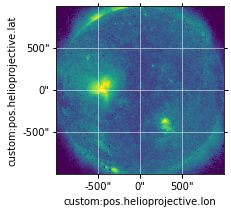

In [5]:
plt.figure(figsize=(3,8))
ax = moxsi_cube[1073//2].plot(norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()))
lon,lat = ax.coords
lon.grid(color='white', alpha=1, linestyle='solid', lw=.5,)
lat.grid(color='white', alpha=1, linestyle='solid', lw=.5,)

We can then flatten this to an overlappogram, specifying the roll angle (angle between the pixel and world axes, where 0 corresponds to the y-like pixel axis aligned with latitude) and spectral order.

In [6]:
observer = get_earth()

In [34]:
moxsi_overlap = construct_overlappogram(moxsi_cube, angle=0*u.deg, observer=observer, order=1)

We can then plot the overlappogram at a few different "wavelength slices." Note as we move in wavelength space, our latitude grid shifts along the dispersion axis.

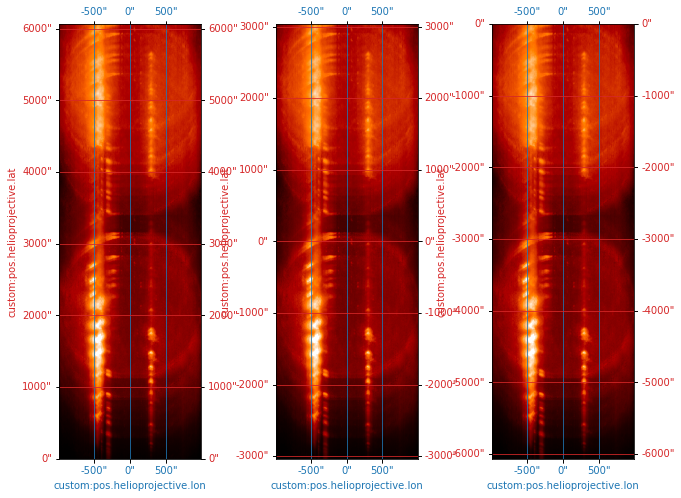

In [40]:
fig = plt.figure(figsize=(11,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})

We can also choose to orient the pixel (and thus the dispersion) axis at some non-zero angle relative to the world axes.

In [48]:
moxsi_overlap = construct_overlappogram(moxsi_cube, angle=45*u.deg, observer=observer, order=1)

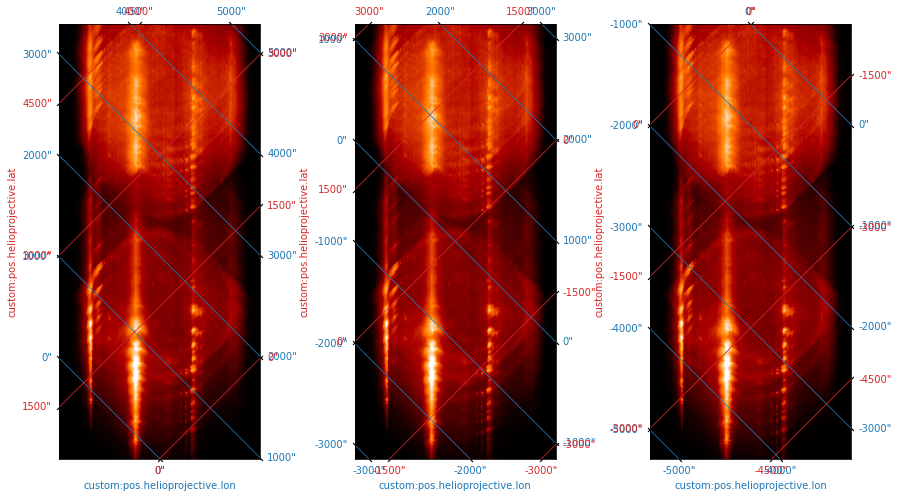

In [45]:
fig = plt.figure(figsize=(15,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    lon,lat = color_lat_lon_axes(ax,
                                 lon_tick_ops={'spacing':1000*u.arcsec},
                                 lat_tick_ops={'spacing':1500*u.arcsec})

Or completely in the "longitude" direction

In [51]:
moxsi_overlap = construct_overlappogram(moxsi_cube, angle=90*u.deg, observer=observer, order=1)

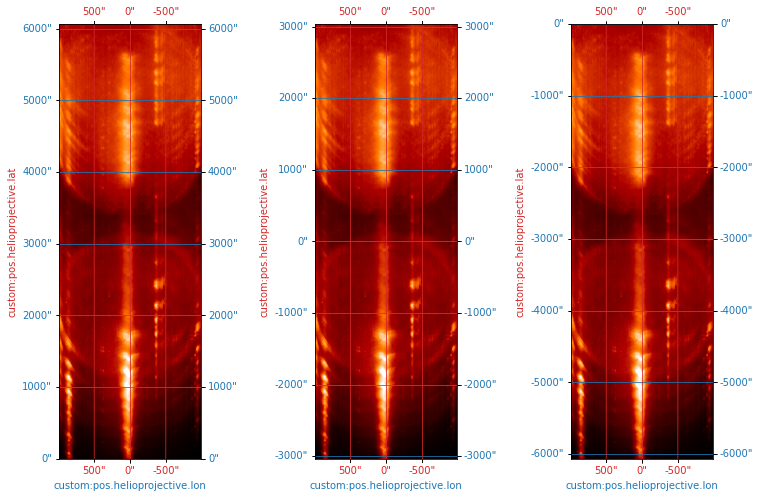

In [52]:
fig = plt.figure(figsize=(13,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lon_tick_ops={'spacing':1000*u.arcsec})

What if we change the order?

In [53]:
m1 = construct_overlappogram(moxsi_cube,angle=0*u.deg,order=1,observer=observer)
m3 = construct_overlappogram(moxsi_cube,angle=0*u.deg,order=3,observer=observer)

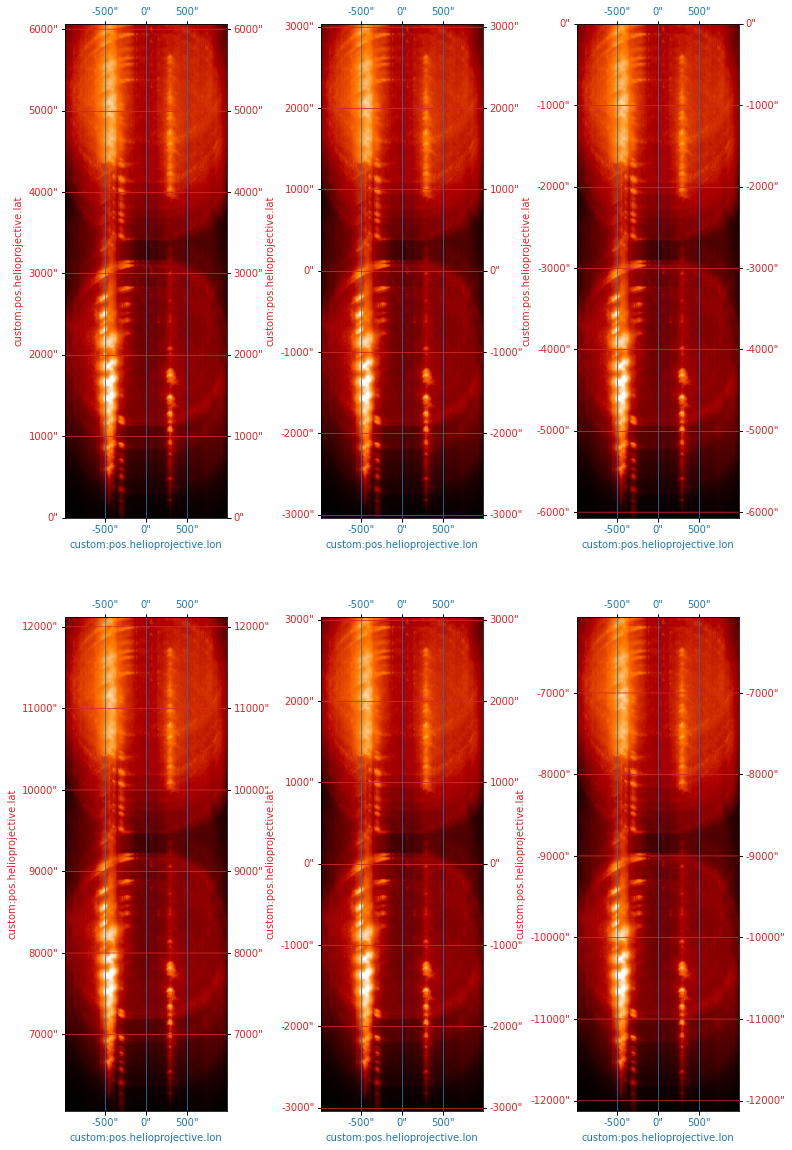

In [58]:
fig = plt.figure(figsize=(13,20))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),i+1, projection=m1[iw].wcs)
    m1[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),len(wvl_indices)+i+1, projection=m3[iw].wcs)
    m3[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})